# (과제용)

## 1) 데이터 준비와 확인

In [ ]:
# 데이터 다운로드 - 깃허브
#!git clone https://github.com/e9t/nsmc.git

In [1]:
# konlpy 설치
#!pip install -q konlpy

In [ ]:
# Mecab 설치 1
#! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

In [10]:
# Mecab 설치 2
#%cd Mecab-ko-for-Google-Colab

/content/Mecab-ko-for-Google-Colab


In [ ]:
# Mecab 설치 3
# !bash install_mecab-ko_on_colab_light_220429.sh

In [17]:
import pandas
import konlpy
import gensim
import pandas as pd
import seaborn as sns

In [45]:
# 데이터를 읽어봅시다.
train_data = pd.read_table('/content/nsmc/ratings_train.txt')
test_data = pd.read_table('/content/nsmc/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [91]:
from konlpy.tag import Mecab, Okt
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 중복 데이터 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words - 4)
    #vocab = ['', '', '', ''] + [key for key, _ in counter]
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]

    word_to_index = {word: index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        # return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)


In [92]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [96]:
for i in range(10):
  print(index_to_word[i])

<PAD>
<BOS>
<UNK>
<UNUSED>
.
영화
다
고
하
을


In [93]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [94]:
get_decoded_sentence(X_train[0], index_to_word)

'더 빙 . . 진짜 짜증 나 네요 목소리'

## 3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

### 데이터셋 내 문장 길이 분포

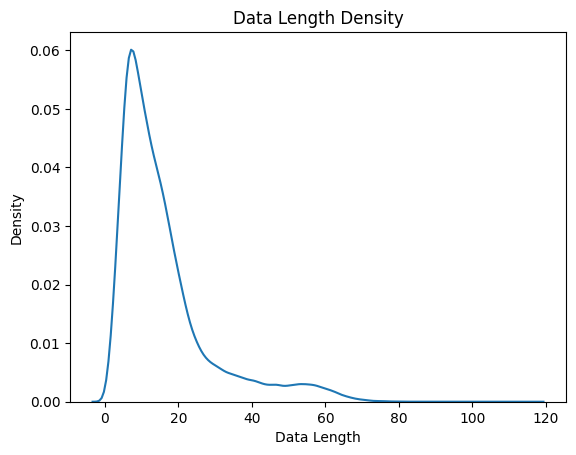

In [97]:
# 문장 길이에 따른 밀도 그래프
total_data_text = list(X_train) + list(X_test)

data_lengths = [len(data) for data in total_data_text]

# 밀도 그래프 생성
sns.kdeplot(data_lengths)
plt.xlabel('Data Length')
plt.ylabel('Density')
plt.title('Data Length Density')
plt.show()


### 적절한 최대 문장 길이 지정

> 아래 코드로 maxlen 지정

```python
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
```

In [98]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 최소 : ', np.min(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
# 데이터의 분포를 파악하고, 데이터 포인트가 어느 정도 퍼져있는지를 판단하는 데 활용됩니다.
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')
# 580 이상인 문장은 잘라냄

문장길이 평균 :  15.971019612059036
문장길이 최대 :  116
문장길이 최소 :  0
문장길이 표준편차 :  12.844062009473816
pad_sequences maxlen :  41
전체 문장의 0.9342629991962691%가 maxlen 설정값 이내에 포함됩니다. 


### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [99]:
# padding
# RNN 구조상 나중에 실제 데이터가 있는게 나음(성능 10% 차이났음)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=0,
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=0,
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)


## 4) 모델 구성 및 validation set 구성

- 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

### 모델 설계 & 훈련

In [118]:
vocab_size = len(index_to_word)    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

#### LSTM

In [119]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_LSTM = tf.keras.Sequential()
# 1
model_LSTM.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_LSTM.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_LSTM.add(tf.keras.layers.Dense(8, activation='relu'))
model_LSTM.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 300)         3000000   
                                                                 
 lstm_6 (LSTM)               (None, 8)                 9888      
                                                                 
 dense_16 (Dense)            (None, 8)                 72        
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


#### CNN

In [ ]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_CNN = tf.keras.Sequential()
# 2
model_CNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.MaxPooling1D(5))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.GlobalMaxPooling1D())
model_CNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_CNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          1808      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

#### GlobalMaxPooling1D

In [ ]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_GMP = tf.keras.Sequential()
# 3
model_GMP.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_GMP.add(tf.keras.layers.GlobalMaxPooling1D())
model_GMP.add(tf.keras.layers.Dense(8, activation='relu'))
model_GMP.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_GMP.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


## 5) 모델 훈련 개시

In [120]:
len(X_train)

146182

In [121]:
# validation set 146182건 분리
# train : valid = 100000 : 46182
x_val = X_train[:46182]
y_val = y_train[:46182]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[46182:]
partial_y_train = y_train[46182:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(100000, 41)
(100000,)


In [122]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history = model_LSTM.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1024,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
98/98 [==============================] - 40s 380ms/step - loss: 0.5796 - accuracy: 0.7222 - val_loss: 0.5025 - val_accuracy: 0.8360
Epoch 2/10
98/98 [==============================] - 36s 367ms/step - loss: 0.4803 - accuracy: 0.8502 - val_loss: 0.4816 - val_accuracy: 0.8418
Epoch 3/10
98/98 [==============================] - 37s 374ms/step - loss: 0.4441 - accuracy: 0.8655 - val_loss: 0.4703 - val_accuracy: 0.8420
Epoch 4/10
98/98 [==============================] - 36s 371ms/step - loss: 0.4166 - accuracy: 0.8760 - val_loss: 0.4629 - val_accuracy: 0.8410
Epoch 5/10
98/98 [==============================] - 37s 379ms/step - loss: 0.3928 - accuracy: 0.8849 - val_loss: 0.4583 - val_accuracy: 0.8421
Epoch 6/10
98/98 [==============================] - 35s 363ms/step - loss: 0.3719 - accuracy: 0.8921 - val_loss: 0.4654 - val_accuracy: 0.8419
Epoch 7/10
98/98 [==============================] - 41s 417ms/step - loss: 0.3542 - accuracy: 0.8971 - val_loss: 0.4587 - val_accuracy: 0.8393

In [123]:
results = model_LSTM.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 11s - loss: 0.4687 - accuracy: 0.8322 - 11s/epoch - 7ms/step
[0.4687405824661255, 0.8322314023971558]


## 6) Loss, Accuracy 그래프 시각화

In [124]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


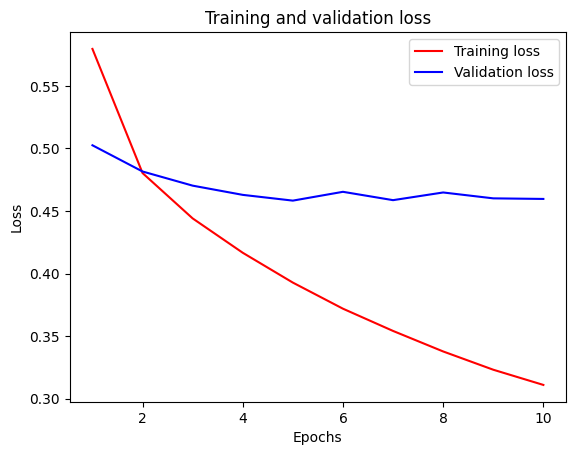

In [125]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'r', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

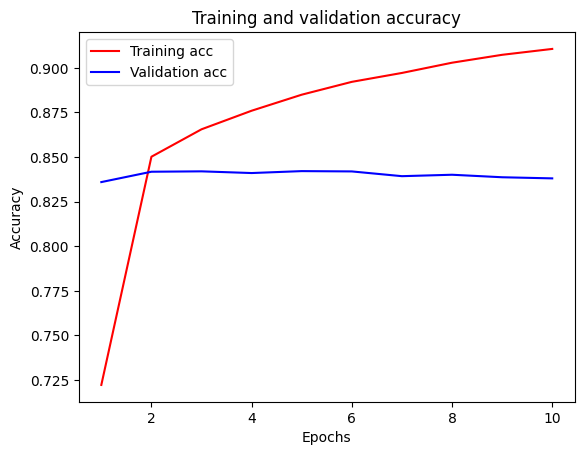

In [126]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석

- train loss는 확실히 감소하지만, valid loss는 감소가 거의 없음 -> 학습종료?

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. 참고 링크1, 참고 링크2

### 박규병님

- [깃허브 링크](https://github.com/Kyubyong/wordvectors)
- [구글드라이브 링크](https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view?resourcekey=0-Dq9yyzwZxAqT3J02qvnFwg)

In [127]:
!pip install -q gdown

In [131]:
import gdown

url = 'https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view?resourcekey=0-Dq9yyzwZxAqT3J02qvnFwg'
output = 'ko.zip'  # 파일을 저장할 경로와 파일 이름을 지정합니다.

gdown.download(url, output)

Downloading...
From: https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view?resourcekey=0-Dq9yyzwZxAqT3J02qvnFwg
To: /content/ko.zip
80.5kB [00:00, 33.0MB/s]


'ko.zip'

In [132]:
import zipfile

zip_file = "/content/ko.zip"
target_directory = "./"

# Zip 파일 열기
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # 압축 파일을 특정 디렉토리에 추출
    zip_ref.extractall(target_directory)

print("압축 파일이 성공적으로 추출되었습니다.")


BadZipFile: ignored

In [130]:
ko_model = gensim.models.Word2Vec.load('/content/ko.bin')
a = ko_model.wv.most_similar("강아지")

UnpicklingError: ignored